## **Churn Prediction and Business Insight with Data Science at MTN Nigeria**

This project was built using the “MTN Nigeria Customer Churn” dataset taken from Kaggle (https://www.kaggle.com/datasets/oluwademiladeadeniyi/mtn-nigeria-customer-churn/). MTN Nigeria is one of the largest telecommunications service providers in Nigeria and the main branch of the MTN group, with millions of customers across the country.

With this workflow, I hope to generate actionable insights to help MTN Nigeria reduce churn and improve customer retention.

>**Disclaimer:**
**_The analysis and insights in this project were prepared as part of a personal data analysis and business skills development exercise. The data used is from open sources. Each insight aims to exercise an analytical mindset and is not intended as a professional business recommendation._**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder 
import warnings

In [2]:
data = pd.read_csv('Dataset/mtn_customer_churn.csv')

df = data.copy()

### **Problem Understanding**

In [3]:
df.head()

,Customer ID,Full Name,Date of Purchase,Age,State,MTN Device,Gender,Satisfaction Rate,Customer Review,Customer Tenure in months,Subscription Plan,Unit Price,Number of Times Purchased,Total Revenue,Data Usage,Customer Churn Status,Reasons for Churn
0,CUST0001,Ngozi Berry,Jan-25,27,Kwara,4G Router,Male,2,Fair,2,165GB Monthly Plan,35000,19,665000,44.48,Yes,Relocation
1,CUST0002,Zainab Baker,Mar-25,16,Abuja (FCT),Mobile SIM Card,Female,2,Fair,22,12.5GB Monthly Plan,5500,12,66000,19.79,Yes,Better Offers from Competitors
2,CUST0003,Saidu Evans,Mar-25,21,Sokoto,5G Broadband Router,Male,1,Poor,60,150GB FUP Monthly Unlimited,20000,8,160000,9.64,No,NaN
3,CUST0003,Saidu Evans,Mar-25,21,Sokoto,Mobile SIM Card,Male,1,Poor,60,1GB+1.5mins Daily Plan,500,8,4000,197.05,No,NaN
4,CUST0003,Saidu Evans,Mar-25,21,Sokoto,Broadband MiFi,Male,1,Poor,60,30GB Monthly Broadband Plan,9000,15,135000,76.34,No,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Customer ID                974 non-null    object 
 1   Full Name                  974 non-null    object 
 2   Date of Purchase           974 non-null    object 
 3   Age                        974 non-null    int64  
 4   State                      974 non-null    object 
 5   MTN Device                 974 non-null    object 
 6   Gender                     974 non-null    object 
 7   Satisfaction Rate          974 non-null    int64  
 8   Customer Review            974 non-null    object 
 9   Customer Tenure in months  974 non-null    int64  
 10  Subscription Plan          974 non-null    object 
 11  Unit Price                 974 non-null    int64  
 12  Number of Times Purchased  974 non-null    int64  
 13  Total Revenue              974 non-null    int64  

In [5]:
churn_percentage = df.groupby(by='Full Name').agg({
    'Customer ID': 'first', 
    'Total Revenue': 'sum', 
    'Customer Churn Status': 'first'
})

churn_percentage.head(2)

,Customer ID,Total Revenue,Customer Churn Status
Full Name,,,
Abubakar Bullock,CUST0436,180500,Yes
Abubakar Ewing,CUST0061,460000,No


In [6]:
churn_percentage = (round((len(churn_percentage[churn_percentage['Customer Churn Status'] == 'Yes']) / len(churn_percentage)) * 100, 2) )

print(f'Percentage of customers who churned: {churn_percentage}%')

Percentage of customers who churned: 29.13%


Customer churn is one of the biggest concerns for telecom companies, especially in competitive markets like Nigeria.

This issue requires serious attention. We need to address it effectively or at least reduce the churn rate. But how? First, we must gain a deeper understanding of two critical metrics:
1. Customer Satisfaction Score (CSAT)
2. Monthly Recurring Revenue 

These metrics are key to identifying the underlying issues. To do this, we should begin by visualizing the data to uncover trends and patterns. Understanding why customers are more likely to churn is essential. Currently, the churn rate stands at 29%, which is significantly high for telecom companies in Nigeria.

For context, the average churn rate for telecom companies in the United States is around 21%, according to ExplodingTopics.com.

### **Data Preparation** 

We need to first understand the data and identify what insights can be extracted from it.

In [7]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Customer ID                    0
Full Name                      0
Date of Purchase               0
Age                            0
State                          0
MTN Device                     0
Gender                         0
Satisfaction Rate              0
Customer Review                0
Customer Tenure in months      0
Subscription Plan              0
Unit Price                     0
Number of Times Purchased      0
Total Revenue                  0
Data Usage                     0
Customer Churn Status          0
Reasons for Churn            690
dtype: int64


In [8]:
# Duplicate values
duplicate_values = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_values}")

Number of duplicate rows: 0


In [9]:
# Check for inconsistent data
data.describe()

,Age,Satisfaction Rate,Customer Tenure in months,Unit Price,Number of Times Purchased,Total Revenue,Data Usage
count,974.000000,974.000000,974.000000,974.000000,974.000000,9.740000e+02,974.000000
mean,48.043121,2.947639,31.422998,19196.663244,10.564682,2.046696e+05,99.304764
std,17.764307,1.384219,17.191256,25586.726985,5.709427,3.247855e+05,57.739511
min,16.000000,1.000000,1.000000,350.000000,1.000000,3.500000e+02,0.820000
25%,32.000000,2.000000,17.000000,5500.000000,5.000000,3.300000e+04,47.637500
50%,49.000000,3.000000,31.000000,14500.000000,11.000000,1.080000e+05,103.330000
75%,63.750000,4.000000,47.000000,24000.000000,15.000000,2.610000e+05,149.697500
max,80.000000,5.000000,60.000000,150000.000000,20.000000,3.000000e+06,200.000000


In [10]:
# Get information about the metrics (CSAT and MRR Churn)
mrr_churn = data[data['Customer Churn Status'] == 'Yes']['Total Revenue'].sum()
mrr_total = data['Total Revenue'].sum()
mrr_churn_percentage = (mrr_churn / mrr_total) * 100
print(f"Monthly Recurring Revenue (MRR) Churn: {mrr_churn_percentage:.2f}%")

csat = data['Satisfaction Rate'].value_counts()
csat_good = csat[csat.index.isin([4,5])].sum()
csat_total = data['Satisfaction Rate'].notna().sum()
csat_percentage = (csat_good / csat_total) * 100
print(f"Customer Satisfaction (CSAT): {csat_percentage:.2f}%")

Monthly Recurring Revenue (MRR) Churn: 29.09%
Customer Satisfaction (CSAT): 38.81%


There is nothing concerning in the data quality itself (the dataset is clean). However, from a business perspective, we should be concerned. Metrics such as MRR (Monthly Recurring Revenue) and CSAT (Customer Satisfaction Score) indicate that the business is in poor condition. Therefore, it is crucial to find a solution, starting with visualizing the data for deeper insights.

### **Data Understanding (Visualization)**

In [11]:
numerical = data.select_dtypes(include=['number']).columns
data[numerical].columns

Index(['Age', 'Satisfaction Rate', 'Customer Tenure in months', 'Unit Price',
       'Number of Times Purchased', 'Total Revenue', 'Data Usage'],
      dtype='object')

In [12]:
categorical = data.select_dtypes(include=['object']).columns
data[categorical].columns

Index(['Customer ID', 'Full Name', 'Date of Purchase', 'State', 'MTN Device',
       'Gender', 'Customer Review', 'Subscription Plan',
       'Customer Churn Status', 'Reasons for Churn'],
      dtype='object')

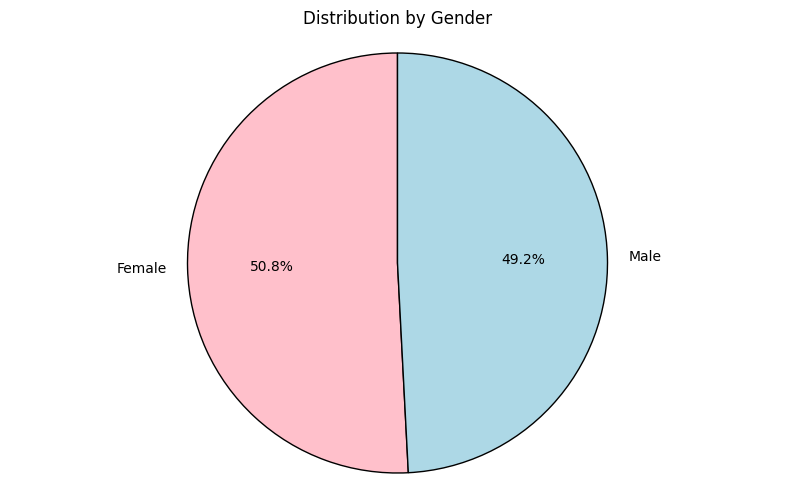

In [13]:
plt.figure(figsize=(10,6))
plt.pie(data['Gender'].value_counts(), labels=df['Gender'].value_counts().index, autopct='%1.1f%%', colors=['pink', 'lightblue'], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution by Gender')
plt.axis('equal')
plt.show()

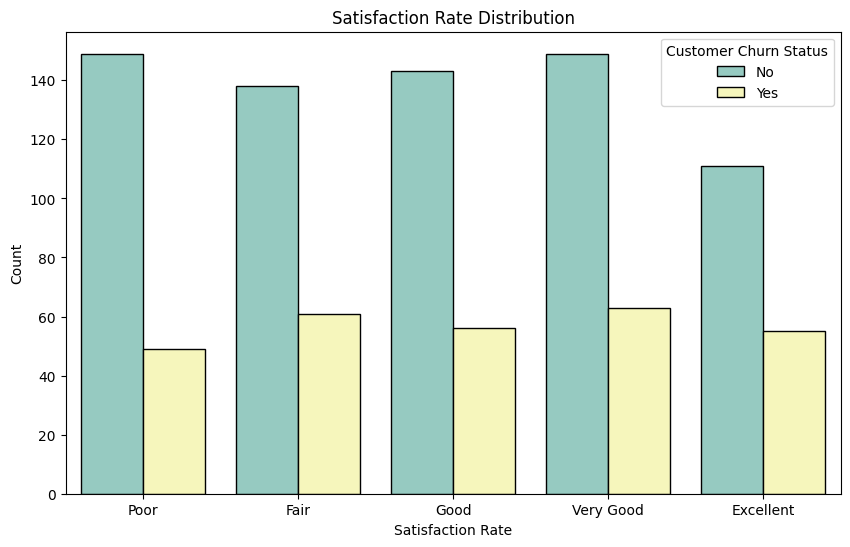

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Satisfaction Rate', hue='Customer Churn Status' ,data=data, palette='Set3', edgecolor='black')
plt.title('Satisfaction Rate Distribution')
plt.xlabel('Satisfaction Rate')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["Poor", "Fair", "Good", "Very Good", "Excellent"])
plt.show()

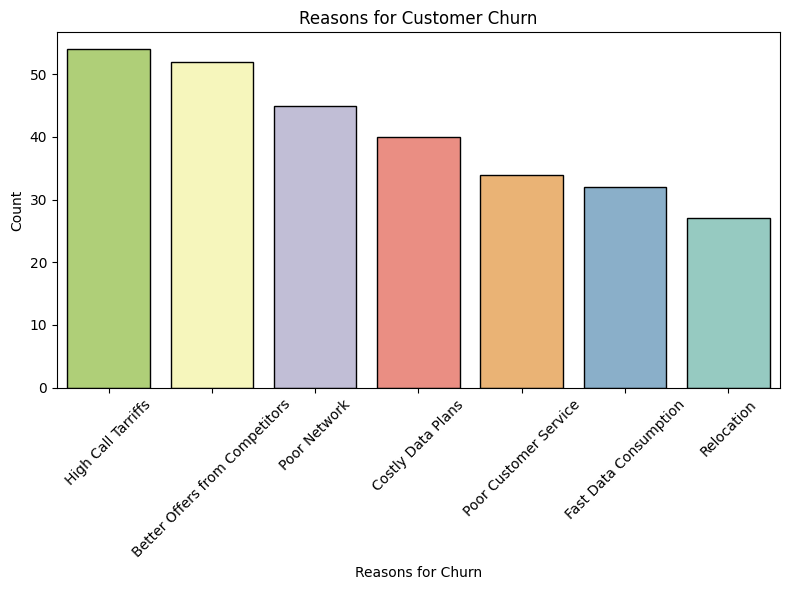

In [15]:
order = data[data['Customer Churn Status'] == 'Yes']['Reasons for Churn'].value_counts().index
plt.figure(figsize=(8, 6))
sns.countplot(data=data[data['Customer Churn Status'] == 'Yes'], x='Reasons for Churn', hue='Reasons for Churn',order=order, palette='Set3', edgecolor='black')
plt.title('Reasons for Customer Churn')
plt.xlabel('Reasons for Churn')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
high_call = data[data['Customer Churn Status'] == 'Yes'][data[data['Customer Churn Status'] == 'Yes']['Reasons for Churn'] == 'High Call Tarriffs']
print(f"Number of customers who churned due to high call tariffs: {len(high_call)}")
high_call.head(2)

Number of customers who churned due to high call tariffs: 54


,Customer ID,Full Name,Date of Purchase,Age,State,MTN Device,Gender,Satisfaction Rate,Customer Review,Customer Tenure in months,Subscription Plan,Unit Price,Number of Times Purchased,Total Revenue,Data Usage,Customer Churn Status,Reasons for Churn
183,CUST0097,Ese Perez,Feb-25,55,Zamfara,5G Broadband Router,Female,3,Good,53,200GB Monthly Broadband Plan,25000,2,50000,172.50,Yes,High Call Tarriffs
220,CUST0116,Bola Garcia,Mar-25,30,Benue,Mobile SIM Card,Male,4,Very Good,29,16.5GB+10mins Monthly Plan,6500,16,104000,155.11,Yes,High Call Tarriffs


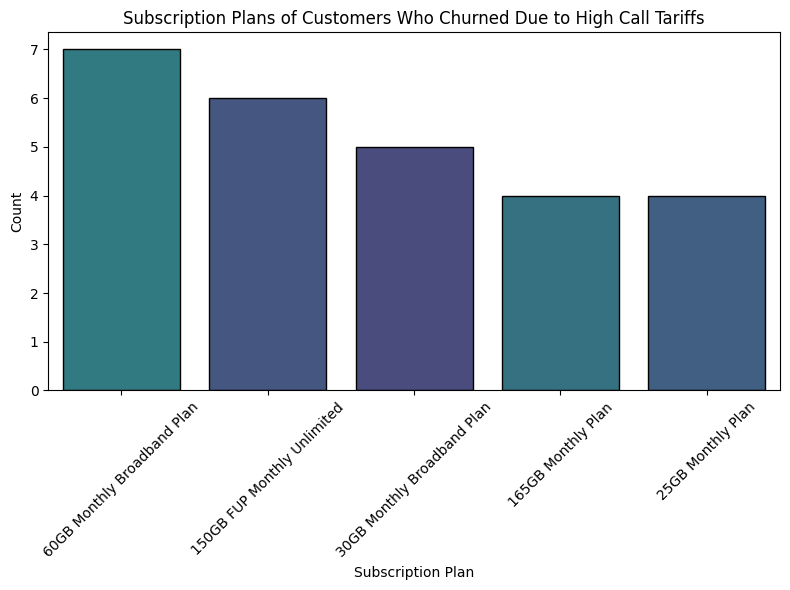

In [17]:
order = high_call['Subscription Plan'].value_counts().head(5).index
plt.figure(figsize=(8, 6))
sns.countplot(data=high_call, x='Subscription Plan', hue='Subscription Plan', order=order, palette='viridis', edgecolor='black')
plt.title('Subscription Plans of Customers Who Churned Due to High Call Tariffs')
plt.xlabel('Subscription Plan')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60']

tenure_binned = pd.cut(data[data['Customer Churn Status'] == 'Yes']['Customer Tenure in months'],bins=bins, labels=labels, right=True, include_lowest=True)

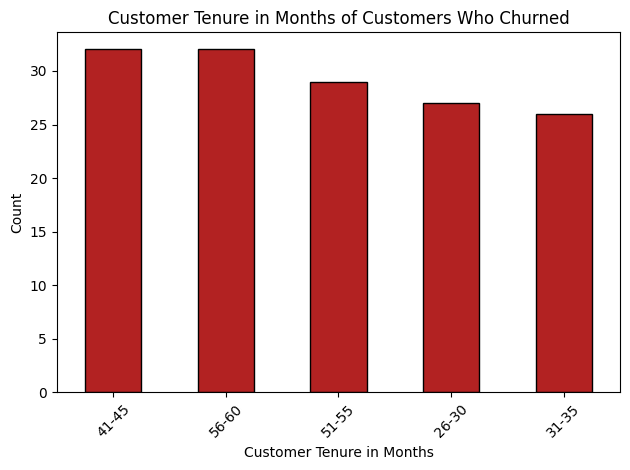

In [19]:
tenure_binned.value_counts().head(5).plot(kind='bar', color='firebrick', edgecolor='black')
plt.title('Customer Tenure in Months of Customers Who Churned')
plt.xlabel('Customer Tenure in Months')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

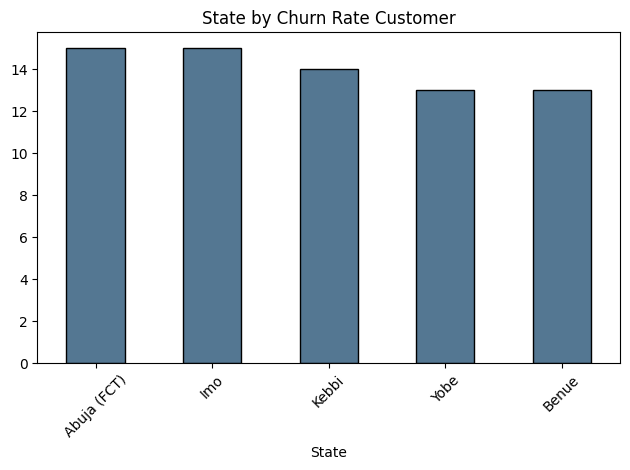

In [20]:
state_churn = data[data['Customer Churn Status'] == 'Yes']['State']
state_churn.columns = ['State', 'Count']
state_churn.value_counts().head(5).plot(kind='bar', color='#547792', edgecolor='Black')
plt.xlabel('State')
plt.title("State by Churn Rate Customer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

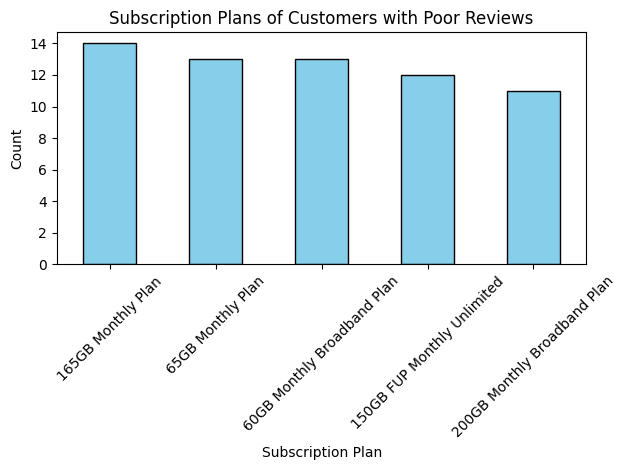

In [21]:
bottom_reviews = data[data['Customer Churn Status'] == 'Yes'][data[data['Customer Churn Status'] == 'Yes']['Customer Review'].isin(['Good', 'Fair', 'Poor'])]
bottom_reviews['Subscription Plan'].value_counts().head(5).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Subscription Plans of Customers with Poor Reviews')
plt.xlabel('Subscription Plan')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

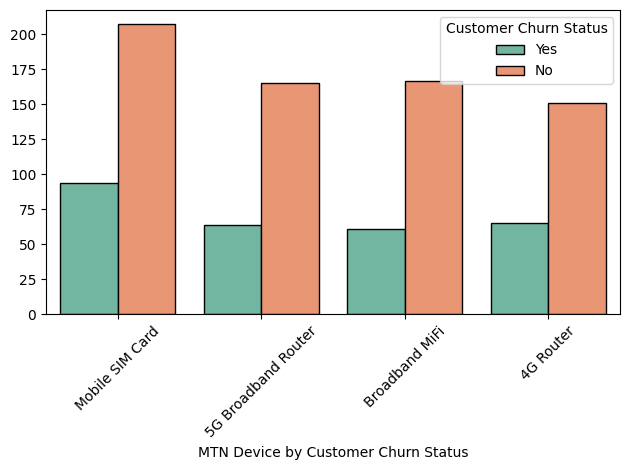

In [22]:
sns.countplot(data=data, hue='Customer Churn Status', x='MTN Device', order=data["MTN Device"].value_counts().index, palette='Set2', edgecolor='Black')
plt.xlabel('MTN Device by Customer Churn Status')
plt.ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
data[data['MTN Device'] == '4G Router']['Customer Churn Status'].value_counts()

Customer Churn Status
No     151
Yes     65
Name: count, dtype: int64

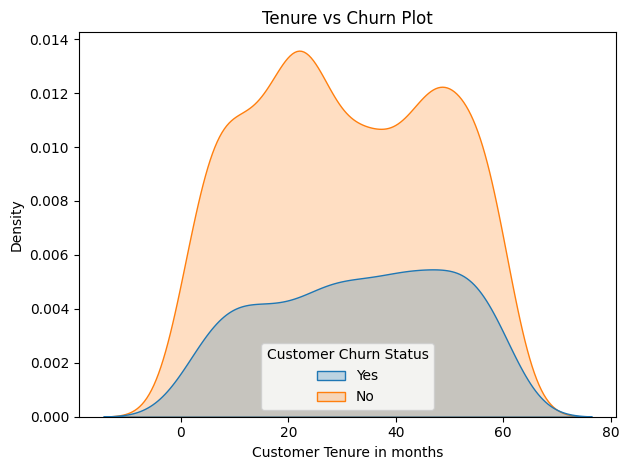

In [24]:
sns.kdeplot(data=df, x='Customer Tenure in months', hue='Customer Churn Status', fill=True)
plt.title("Tenure vs Churn Plot")
plt.tight_layout()
plt.show()

In [25]:
encoder = LabelEncoder()
data.head(2)

,Customer ID,Full Name,Date of Purchase,Age,State,MTN Device,Gender,Satisfaction Rate,Customer Review,Customer Tenure in months,Subscription Plan,Unit Price,Number of Times Purchased,Total Revenue,Data Usage,Customer Churn Status,Reasons for Churn
0,CUST0001,Ngozi Berry,Jan-25,27,Kwara,4G Router,Male,2,Fair,2,165GB Monthly Plan,35000,19,665000,44.48,Yes,Relocation
1,CUST0002,Zainab Baker,Mar-25,16,Abuja (FCT),Mobile SIM Card,Female,2,Fair,22,12.5GB Monthly Plan,5500,12,66000,19.79,Yes,Better Offers from Competitors


In [26]:
data_encode = data[["Customer Review", "Customer Churn Status"]].apply(encoder.fit_transform)

data_matrix = pd.concat([data[numerical], data_encode], axis=1)
data_matrix.head()

,Age,Satisfaction Rate,Customer Tenure in months,Unit Price,Number of Times Purchased,Total Revenue,Data Usage,Customer Review,Customer Churn Status
0,27,2,2,35000,19,665000,44.48,1,1
1,16,2,22,5500,12,66000,19.79,1,1
2,21,1,60,20000,8,160000,9.64,3,0
3,21,1,60,500,8,4000,197.05,3,0
4,21,1,60,9000,15,135000,76.34,3,0


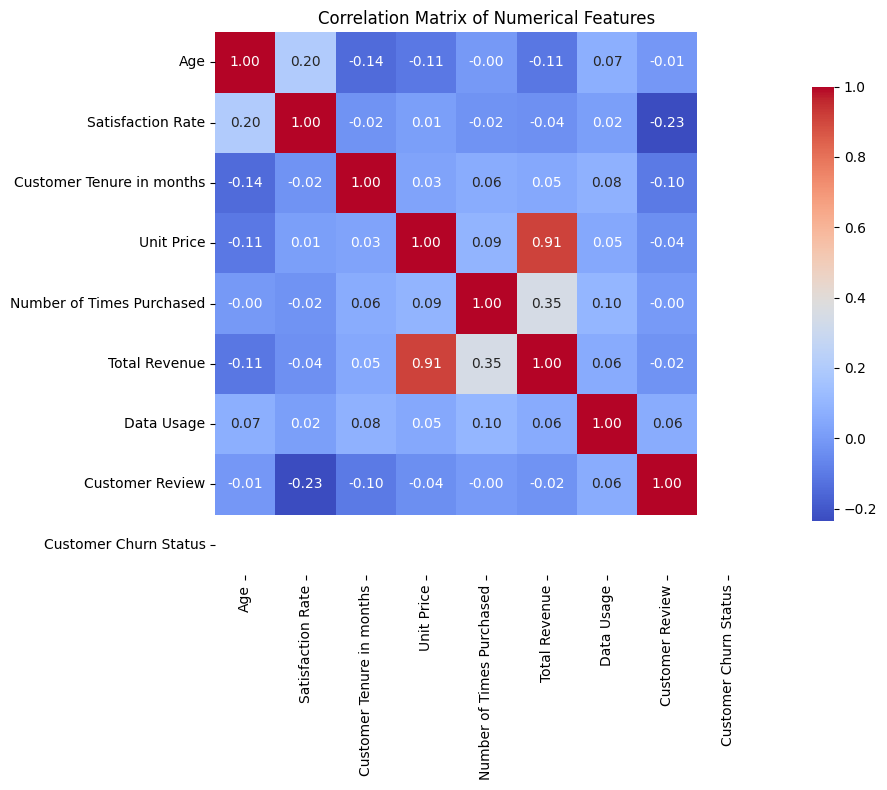

In [27]:
matrix = data_matrix[data_matrix['Customer Churn Status'] == 1].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

### **Machine Learning Workflow**

We aim to predict customers who are at risk of churning.

In [28]:
data.head(2)

,Customer ID,Full Name,Date of Purchase,Age,State,MTN Device,Gender,Satisfaction Rate,Customer Review,Customer Tenure in months,Subscription Plan,Unit Price,Number of Times Purchased,Total Revenue,Data Usage,Customer Churn Status,Reasons for Churn
0,CUST0001,Ngozi Berry,Jan-25,27,Kwara,4G Router,Male,2,Fair,2,165GB Monthly Plan,35000,19,665000,44.48,Yes,Relocation
1,CUST0002,Zainab Baker,Mar-25,16,Abuja (FCT),Mobile SIM Card,Female,2,Fair,22,12.5GB Monthly Plan,5500,12,66000,19.79,Yes,Better Offers from Competitors


In [29]:
data[numerical].head(2)

,Age,Satisfaction Rate,Customer Tenure in months,Unit Price,Number of Times Purchased,Total Revenue,Data Usage
0,27,2,2,35000,19,665000,44.48
1,16,2,22,5500,12,66000,19.79


In [30]:
data_numerical = data[numerical]
data_numerical = data_numerical.drop(columns=['Age', 'Number of Times Purchased', 'Total Revenue']) # Delete the columns because correlation almost 0
data_numerical.head(2)

,Satisfaction Rate,Customer Tenure in months,Unit Price,Data Usage
0,2,2,35000,44.48
1,2,22,5500,19.79


In [31]:
data_encode = data[["State", "Subscription Plan", "Customer Review", "Customer Churn Status"]].apply(encoder.fit_transform)
new_data = pd.concat([data_numerical, data_encode], axis=1)
new_data.head(2)

,Satisfaction Rate,Customer Tenure in months,Unit Price,Data Usage,State,Subscription Plan,Customer Review,Customer Churn Status
0,2,2,35000,44.48,22,7,1,1
1,2,22,5500,19.79,1,3,1,1


In [32]:
# Add New Features
new_data['loyalty_score'] = new_data['Satisfaction Rate']*df['Customer Tenure in months']
new_data['estimated_spend'] = new_data['Unit Price']*new_data['Data Usage']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(new_data.drop(columns=['Customer Churn Status']), new_data['Customer Churn Status'], test_size=0.2, random_state=42)

In [34]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    selector = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy')
    selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_]
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    final_model = model
    final_model.fit(X_train_sel, y_train)
    score = final_model.score(X_test_sel, y_test)
    return score, selected_features.values

def evaluate_model_2(model, X_train, y_train, X_test, y_test):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()]
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    final_model = model
    final_model.fit(X_train_sel, y_train)
    score = final_model.score(X_test_sel, y_test)
    return score, selected_features.values

In [35]:
model_dt = DecisionTreeClassifier(random_state=42)

score_dt, selected_features_dt = evaluate_model(model_dt, X_train, y_train, X_test, y_test)
print(f"Decision Tree Classifier Accuracy: {score_dt:.2f}\nPemilihan Fitur: {selected_features_dt}")

Decision Tree Classifier Accuracy: 0.73
Pemilihan Fitur: ['State' 'loyalty_score' 'estimated_spend']


In [36]:
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)

score_rf, selected_features_rf = evaluate_model(model_rf,  X_train, y_train, X_test, y_test)
print(f"Random Forest Classifier Accuracy: {score_rf:.2f}\nPemilihan Fitur: {selected_features_rf}")

Random Forest Classifier Accuracy: 0.77
Pemilihan Fitur: ['Customer Tenure in months' 'Data Usage' 'State' 'loyalty_score'
 'estimated_spend']


In [37]:
model_gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)

score_gbc, selected_features_gbc = evaluate_model_2(model_gbc,  X_train, y_train, X_test, y_test)
print(f"Random Gradient Boosting Classifier Accuracy: {score_gbc:.2f}\nPemilihan Fitur: {selected_features_gbc}")

Random Gradient Boosting Classifier Accuracy: 0.72
Pemilihan Fitur: ['Satisfaction Rate' 'Customer Tenure in months' 'Unit Price' 'Data Usage'
 'State' 'Subscription Plan' 'Customer Review' 'loyalty_score'
 'estimated_spend']


In [38]:
model_knn = KNeighborsClassifier(n_neighbors=5)

score_knn, selected_features_knn = evaluate_model_2(model_knn,  X_train, y_train, X_test, y_test)
print(f"Random KNN Accuracy: {score_knn:.2f}\nPemilihan Fitur: {selected_features_knn}")

Random KNN Accuracy: 0.64
Pemilihan Fitur: ['Satisfaction Rate' 'Customer Tenure in months' 'Unit Price' 'Data Usage'
 'State' 'Subscription Plan' 'Customer Review' 'loyalty_score'
 'estimated_spend']


### **Evaluation Model**

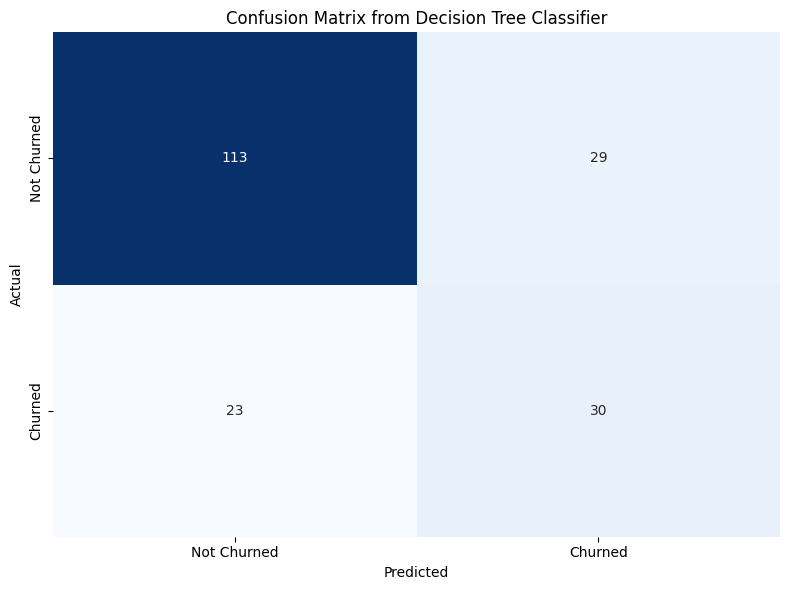

In [39]:
cm_dt = confusion_matrix(y_test, model_dt.predict(X_test[selected_features_dt]))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix from Decision Tree Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [40]:
recall_churn_dt = cm_dt[1, 1] / (cm_dt[1, 1] + cm_dt[1, 0])
precision_churn_dt = cm_dt[1, 1] / (cm_dt[1, 1] + cm_dt[0, 1])
f1_churn_dt = 2 * (recall_churn_dt * precision_churn_dt) / (recall_churn_dt + precision_churn_dt)

print("Decision Tree Classifier Metrics:")
print("---------------------------------")
print(f"Recall for Churned Customers: {recall_churn_dt:.2f}")
print(f"Precision for Churned Customers: {precision_churn_dt:.2f}")
print(f"F1 Score for Churned Customers: {f1_churn_dt:.2f}")

Decision Tree Classifier Metrics:
---------------------------------
Recall for Churned Customers: 0.57
Precision for Churned Customers: 0.51
F1 Score for Churned Customers: 0.54


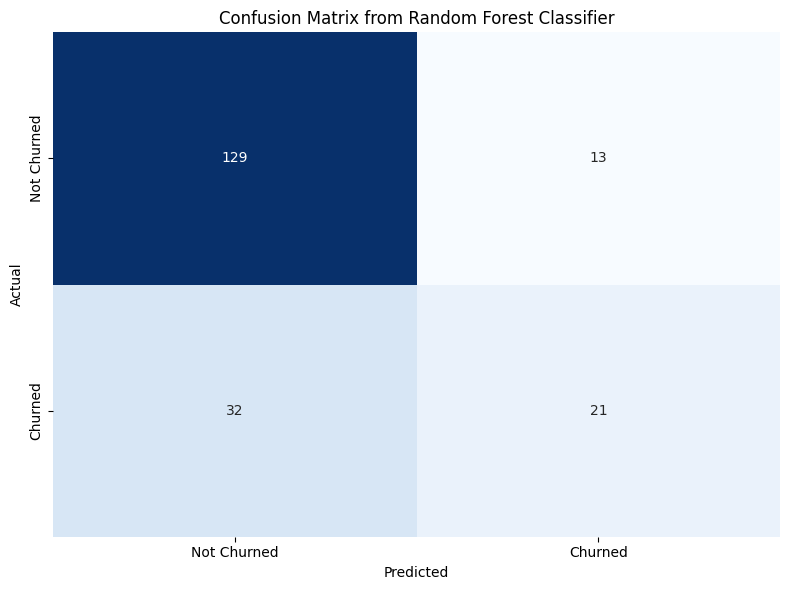

In [41]:
cm_rf = confusion_matrix(y_test, model_rf.predict(X_test[selected_features_rf]))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix from Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [42]:
recall_churn_rf = cm_rf[1, 1] / (cm_rf[1, 1] + cm_rf[1, 0])
precision_churn_rf = cm_rf[1, 1] / (cm_rf[1, 1] + cm_rf[0, 1])
f1_churn_rf = 2 * (recall_churn_rf * precision_churn_rf) / (recall_churn_rf + precision_churn_rf)

print("Random Forest Classifier Metrics:")
print("---------------------------------")
print(f"Recall for Churned Customers: {recall_churn_rf:.2f}")
print(f"Precision for Churned Customers: {precision_churn_rf:.2f}")
print(f"F1 Score for Churned Customers: {f1_churn_rf:.2f}")

Random Forest Classifier Metrics:
---------------------------------
Recall for Churned Customers: 0.40
Precision for Churned Customers: 0.62
F1 Score for Churned Customers: 0.48


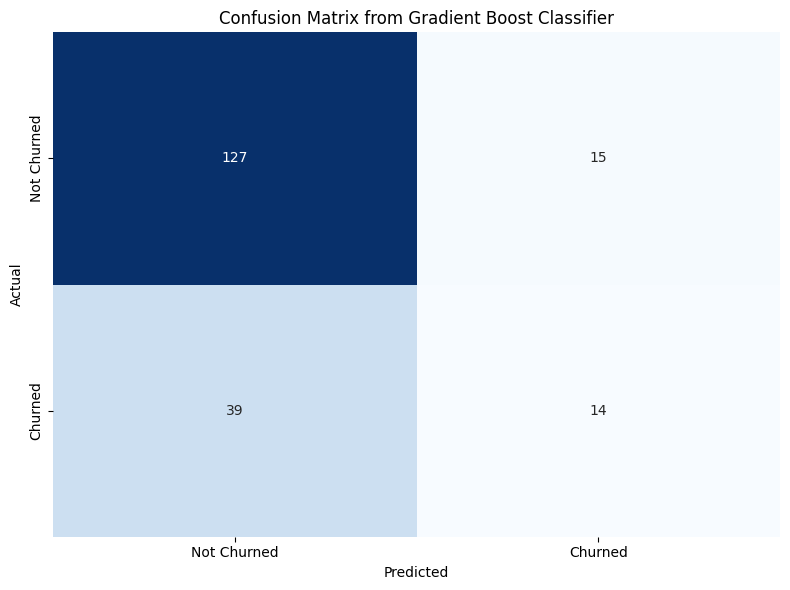

In [43]:
cm_gbc = confusion_matrix(y_test, model_gbc.predict(X_test[selected_features_gbc]))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbc, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix from Gradient Boost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [44]:
recall_churn_gbc = cm_gbc[1, 1] / (cm_gbc[1, 1] + cm_gbc[1, 0])
precision_churn_gbc = cm_gbc[1, 1] / (cm_gbc[1, 1] + cm_gbc[0, 1])
f1_churn_gbc = 2 * (recall_churn_gbc * precision_churn_gbc) / (recall_churn_gbc + precision_churn_gbc)

print("Gradient Boost Classifier Metrics:")
print("---------------------------------")
print(f"Recall for Churned Customers: {recall_churn_gbc:.2f}")
print(f"Precision for Churned Customers: {precision_churn_gbc:.2f}")
print(f"F1 Score for Churned Customers: {f1_churn_gbc:.2f}")

Gradient Boost Classifier Metrics:
---------------------------------
Recall for Churned Customers: 0.26
Precision for Churned Customers: 0.48
F1 Score for Churned Customers: 0.34


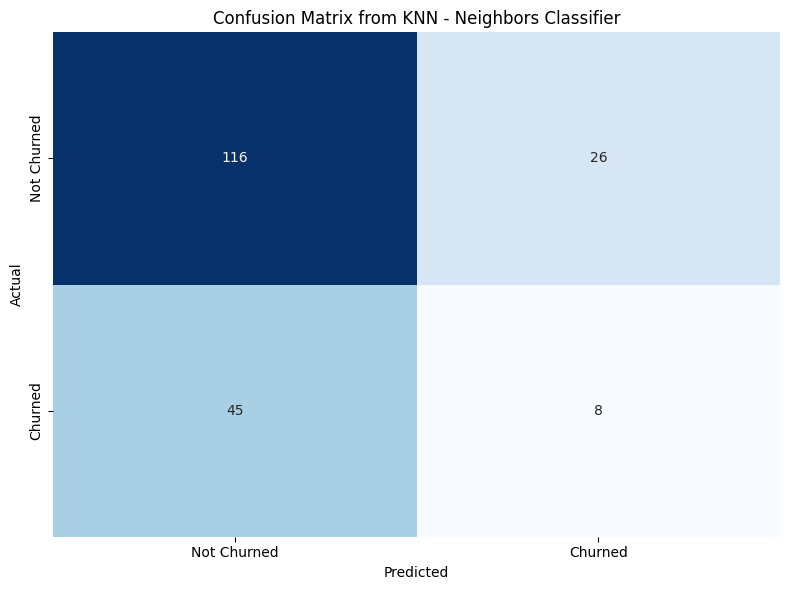

In [45]:
cm_knn = confusion_matrix(y_test, model_knn.predict(X_test[selected_features_knn]))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix from KNN - Neighbors Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [46]:
recall_churn_knn = cm_knn[1, 1] / (cm_knn[1, 1] + cm_knn[1, 0])
precision_churn_knn = cm_knn[1, 1] / (cm_knn[1, 1] + cm_knn[0, 1])
f1_churn_knn = 2 * (recall_churn_knn * precision_churn_knn) / (recall_churn_knn + precision_churn_knn)

print("KNN Classifier Metrics:")
print("-----------------------")
print(f"Recall for Churned Customers: {recall_churn_knn:.2f}")
print(f"Precision for Churned Customers: {precision_churn_knn:.2f}")
print(f"F1 Score for Churned Customers: {f1_churn_knn:.2f}")

KNN Classifier Metrics:
-----------------------
Recall for Churned Customers: 0.15
Precision for Churned Customers: 0.24
F1 Score for Churned Customers: 0.18


### **Prediction**

We will chose Decision Tree as the base model for our approach. Why? Because our primary goal is to quickly identify users who are likely to churn (Decision tree has higher Recall compared to other models). Even if the model misclassifies some retained users as potential churners, it's acceptable. Our objective is to retain as many users as possible.

While this approach may lead to an increase in marketing costs due to targeting users who may not actually churn, it can still effectively help reduce the overall churn rate. Our target is to bring the current churn rate down from 29% to below the 21% industry benchmark.

In [47]:
def predict_churn(model, x_sample):
    y_sample = model.predict([x_sample])
    return y_sample

In [66]:
random_number = random.randrange(1,len(X_test)-1)
x_sample = X_test.iloc[random_number]
y_sample = y_test.iloc[random_number]
print(f"Sample Data:\n{x_sample}\n")
print(f"Sample Data Churn Status: {y_sample}\n")

Sample Data:
Satisfaction Rate                 2.00
Customer Tenure in months        50.00
Unit Price                     9000.00
Data Usage                       28.11
State                            15.00
Subscription Plan                15.00
Customer Review                   1.00
loyalty_score                   100.00
estimated_spend              252990.00
Name: 55, dtype: float64

Sample Data Churn Status: 1



In [67]:
warnings.filterwarnings("ignore", category=UserWarning)
prediction = predict_churn(model_dt, x_sample[selected_features_dt])
if prediction[0] == 1:
    print("🚨 Risk Alert: This customer is likely to churn.")
    print("Recommended Strategy: Proactively reach out with a personalized retention offer or exclusive service benefits.")
else:
    print("✅ Customer Retention Likely.")
    print("Recommended Strategy: Maintain engagement with regular updates and value-driven communication.")

🚨 Risk Alert: This customer is likely to churn.
Recommended Strategy: Proactively reach out with a personalized retention offer or exclusive service benefits.


### **What insights did we get?**

After conducting data exploration and visualization, here are some important findings that can be used as strategic considerations for companies:

1. The difference in churn rate between male and female customers does not show a significant gap. **This suggests that gender is not the main cause of churn and does not need to be prioritized in retention strategies.**
2. Customers who gave Very Good reviews actually contributed the highest churn rate, followed by Fair, Good, and finally Poor. This opens up two possibilities.
    - Customers with good scores (Very Good/Good) keep switching because the competitor's program is more attractive.
    - Poor reviews are very few because it is likely that customers are very disappointed and immediately churn without giving feedback.
    
    **Recommendation: Conduct a follow-up survey of churn customers who previously gave high ratings to explore the main reasons for their move.**
3. The main reason for customer churn is calling rates that are perceived as expensive. The top three products most often associated with churn due to this are:
    - 60GB Monthly Broadband Plan.
    - 150GB FUP Monthly Unlimited.
    - 30GB Monthly Broadband Plan.
    
    **Recommendation: Reevaluate the pricing structure and benefits of these three plans, and compare them with competitors. If necessary, consider relaunching with new, more competitive benefits.**
4. The tenure range with the most churn is between 41-60 months. This suggests that:
    - Existing customers can start to feel bored, disappointed, or tempted by competitors' offerings.
    - The current loyalty program may not be effective enough.
    
    **Recommendation: Create a special retention strategy for existing customers, such as loyalty rewards, exclusive discounts, or special offers to extend the subscription period.**
5. There are 3 regions that should be concerned to reduce the churn rate, namely Abuja (FCT), Imo, and Kebbi. **A deeper analysis needs to be done as to why these three regions account for the largest churn rate**. 
6. Subscribers with Mobile SIM Card devices do account for the largest churn in absolute terms, which is reasonable considering the number of users is much higher than other devices. However, for 4G Router devices, although the total number of users is only around 216, there are around 65 customers who churn, which is equivalent to a 30% churn rate. This is a fairly high churn rate for one type of device.
**Recommendation: Conduct an in-depth analysis of the 4G Router's user experience - such as network speed, stability, plan price, or after-sales service - to determine whether the product is still worth maintaining, upgrading, or needs to be adjusted to a new market strategy.**

Most churn is caused by price and customer perception of service value. To reduce churn, it is important that companies not only focus on acquiring new customers, but also strengthen the value proposition and loyalty of existing customers.

>**Disclaimer:**
**_The analysis and insights in this project were prepared as part of a personal data analysis and business skills development exercise. The data used is from open sources. Each insight aims to exercise an analytical mindset and is not intended as a professional business recommendation._**